In [1]:
import furuta_systems
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import furuta_params
import furuta_trajectory_gen

params_auslegung = furuta_params.FurutaParams()
params_auslegung.mu_H1 = 0.0
params_auslegung.mu_H2 = 0.0
tau_max = params_auslegung.tau_max
operating_point = (0,0,0,0,0)

a) Berechnen Sie die Systemmatrix A und den Eingangsvektor b mit den in Tab. 1
gegebenen Parametern.


In [2]:
#Arbeitspunkt 0, 0, 0, 0, 0
A_lin, b_lin = furuta_systems.get_linear_furuta(params_auslegung, operating_point)
A_lin

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.75161710e+01,  1.07509938e+00,
         4.43968359e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.69687907e+01, -6.23540025e+01,
        -2.57494374e-02]])

In [3]:
b_lin

array([[  0.        ],
       [ 34.40615006],
       [  0.        ],
       [-33.33095788]])

b) Überprüfen Sie die Steuerbarkeit des linearisierten Modells.

In [4]:
# SymPy -> NumPy
A_np = A_lin
b_np = b_lin

n = A_np.shape[0]

# Steuerbarkeitsmatrix S = [B, AB, A^2B, ...]
S_blocks = [np.linalg.matrix_power(A_np, k) @ b_np for k in range(n)] #liste von spalten vektoren
S_np = np.hstack(S_blocks) #spaletenvektoren werden zu matrix zusammen gefügt

rankS = np.linalg.matrix_rank(S_np)  # nutzt intern Toleranz (SVD-basiert)

print("S shape:", S_np.shape)
print("rank(S):", rankS)
print("voll steuerbar?", rankS == n)

S shape: (4, 4)
rank(S): 4
voll steuerbar? True


c) Berechnen Sie die Eigenwerte der Systemmatrix.

In [5]:
np.linalg.eig(A_np)

EigResult(eigenvalues=array([  0.        +0.j        , -17.46681993+0.j        ,
        -0.03755025+7.84119401j,  -0.03755025-7.84119401j]), eigenvectors=array([[ 1.00000000e+00+0.j        , -4.44670392e-02+0.j        ,
        -8.23695775e-04+0.00037581j, -8.23695775e-04-0.00037581j],
       [ 0.00000000e+00+0.j        ,  7.76697767e-01+0.j        ,
        -2.91590107e-03-0.00647287j, -2.91590107e-03+0.00647287j],
       [ 0.00000000e+00+0.j        ,  3.59123592e-02+0.j        ,
        -6.05792834e-04-0.12650086j, -6.05792834e-04+0.12650086j],
       [ 0.00000000e+00+0.j        , -6.27274712e-01+0.j        ,
         9.91940495e-01+0.j        ,  9.91940495e-01-0.j        ]]))

In [6]:
# Symbol für lambda
lam = sp.symbols('λ')

# Charakteristisches Polynom
char_poly = np.poly(A_np)
char_poly

array([1.00000000e+00, 1.75419204e+01, 6.27975005e+01, 1.07396023e+03,
       0.00000000e+00])

d) Überführen Sie das linearisierte System in Regelungsnormalform (RNF) und führen 
Sie einen flachen Ausgang ein.


In [7]:
A_RNF, Q = furuta_systems.get_RNF_furuta(params_auslegung, operating_point)

In [8]:
b_RNF = Q @ b_np
b_RNF


array([[0.00000000e+00],
       [3.46944695e-18],
       [1.92540547e-17],
       [1.00000000e+00]])

e) Erarbeiten Sie auf Basis der RNF eine Steuerung, die zur Überführung zwischen 
stationären Regimen innerhalb eines vorgegebenes Zeitintervall geeignet ist.

In [9]:
# Symbole
n, k = sp.symbols('n k', integer=True, nonnegative=True)
tau = sp.symbols('tau', nonzero=True)

# Formel als SymPy-Ausdruck (allgemein)
phi = sp.factorial(2*n + 1) / sp.factorial(n)**2 * sp.summation(
    sp.binomial(n, k) * (-1)**k * tau**(n + k + 1) / (n + k + 1),
    (k, 0, n)
)

# Beispiel: n = 4
phi4 = sp.simplify(phi.subs(n, 4))
phi4

Piecewise((126*tau**5*hyper((-4, 5), (6,), tau), (tau >= -1) & (tau <= 1)), (tau**5*(70*tau**4 - 315*tau**3 + 540*tau**2 - 420*tau + 126), True))

Trajektorie für den Flachen Ausgang bestimmen:

3.10 Implementieren Sie die erarbeitete Steuerung und simulieren Sie diese mit dem 
nichtlinearen Modell für eine Überführung des Zustandes von der stabilen Ruhelage 


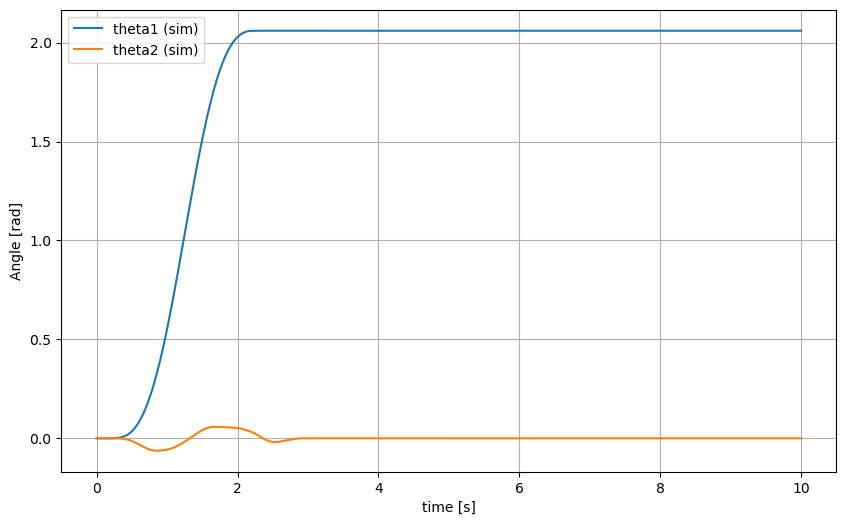

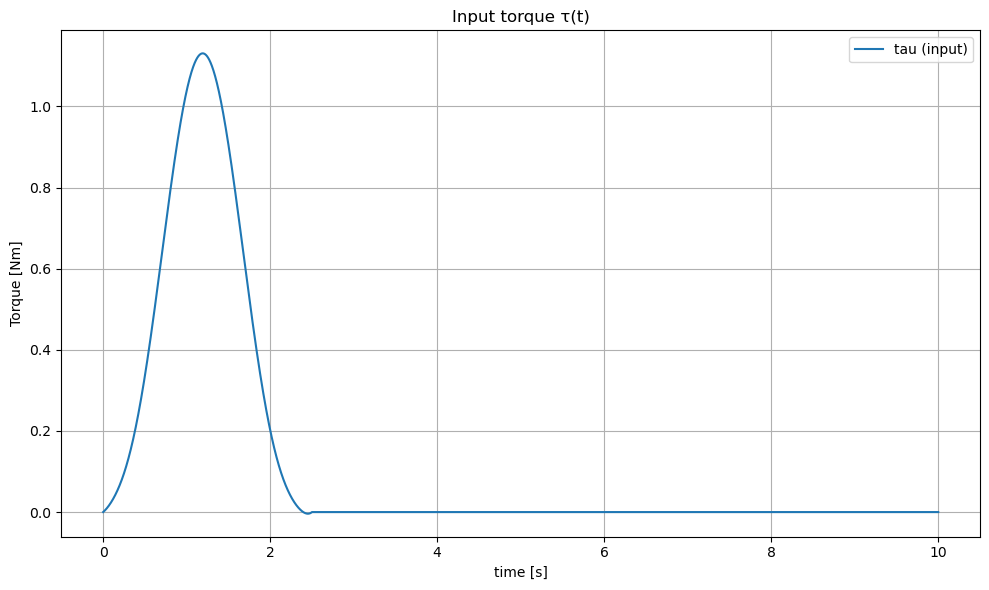

In [10]:
# b0 für Ausgang gleich Theta1 finden
cT = np.array([[1, 0, 0, 0]])
b0, b1, b2, b3 = furuta_systems.get_b_coefficients_furuta(cT, params_auslegung, operating_point)

y0 = 0.0
yT = (140.0/360.0) * 2 * np.pi
eta0 = y0/b0
etaT = yT/b0
t0 = 0
t1 = 2.5

u_ref, x_ref = furuta_trajectory_gen.generate_trajectorys(eta0, etaT, t0, t1, params_auslegung, operating_point)

#u außerhalb des übergangs gleich 0 setzten:
def input_tau(t: float) -> float:
    if t<t0: return 0.0
    if t>t1: return 0.0
    return u_ref(t)

params_sim = furuta_params.FurutaParams()
haft_reibung = True
if not haft_reibung:
    params_sim.mu_H1 = 0.0
    params_sim.mu_H2 = 0.0

non_linear_furuta_system = furuta_systems.get_non_linear_furuta_system(params_sim)

def simulation_system(t, x):
    theta1, theta1_dot, theta2, theta2_dot = x
    u = input_tau(t)
    return non_linear_furuta_system(t, x, u)

x0 = [0.0, 0.0, 0.0, 0.0]
t_sim = np.linspace(0.0, 10.0, 10000)

sol = solve_ivp(
    simulation_system,
    (float(t_sim[0]), float(t_sim[-1])),
    x0,
    t_eval=t_sim,
    rtol=1e-6,
    atol=1e-9,
    max_step=1e-3,
)

theta1_sim = sol.y[0]
theta2_sim = sol.y[2]
tau_sim = np.array([input_tau(t) for t in t_sim])

plt.figure(figsize=(10, 6))
plt.plot(t_sim, theta1_sim, label="theta1 (sim)")
plt.plot(t_sim, theta2_sim, label="theta2 (sim)")
plt.ylabel("Angle [rad]")
plt.xlabel("time [s]")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_sim, tau_sim, label="tau (input)")
plt.ylabel("Torque [Nm]")
plt.xlabel("time [s]")
plt.title("Input torque τ(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()